In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [3]:
import database
reload(database)
db = database.thomas_18_db

In [4]:
figdir_root='/mnt/home/szheng/ceph/place_variability/fig/block_reuse/'
figdir = os.path.join(figdir_root,'pv_corr')
figdir= misc.get_or_create_subdir(figdir)

In [5]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [6]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=True,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 311 ms, sys: 4.84 s, total: 5.15 s
Wall time: 1min 47s


In [8]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [9]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


In [21]:
# def get_support(x,max_thresh=0.5,extend=2):
#     '''
#     x: series, a column of W_hat_ma, place field template/factor; 
#     find the position bin where x is at max_thresh * max, then extend the range by the factor extend
    
#     '''
#     maxlen = x.shape[0]
#     max_thresh_val = x.max()*max_thresh
#     ma = (x - max_thresh_val) > 0
# #     pdb.set_trace()
#     support= np.array(x.index[ma.diff().fillna(False)])
#     extend_side = None
#     if ma.iloc[0]:
#         extend_side='right'
#         support = np.insert(support,0,0)
#     elif ma.iloc[-1]:
#         extend_side = 'left'
#         support = np.append(support,maxlen-1)
        
    
#     if extend is not None:
#         length = support[-1]-support[0]
#         if extend_side is None:
#             len_to_extend_per_side=int(length * (extend-1)//2)
#         else:
#             len_to_extend_per_side=int(length * (extend-1)) # if only one side then extend the whole length in one direction
#         left=max(support[0] - len_to_extend_per_side,0)
#         right=min(support[-1] + len_to_extend_per_side,maxlen-1)
#         support = np.array([*support,left,right])
        
#     return support

# def get_field(W,**kwargs):
#     field_range=W_hat_ma.apply(get_support,axis=0,**kwargs)
#     if field_range.shape[0]==2:
#         field_range.index=['start','end']
#     else:
#         field_range.index=['start','end','window_start','window_end']
#     return field_range.T
        

In [10]:
import reuse_block_analysis as rba
reload(rba)

<module 'reuse_block_analysis' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/reuse_block_analysis.py'>

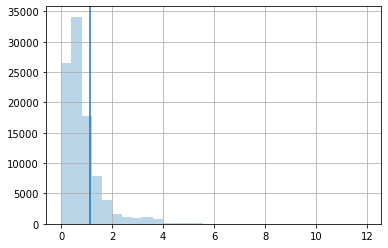

In [29]:
ax=per_cell_metrics['si'].hist(bins=30,alpha=0.3)
thresh=per_cell_metrics['si'].quantile(0.8)
ax.axvline(thresh)


# using normal nmf

In [162]:
exp_ind=('CA1',slice(None),0)
per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
row=per_cell_metrics_oneexp.query('si>1').sample(1,random_state=11)
print(row)
region, exp, day,isnovel,uid=ind=row.index[0]
# region,exp = exp_ind

# region = 'CA1'#'CA3'
# exp = 0#0
# uid = 64#21
# isnovel = 0#1

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_ = X_df_.fillna(axis=0,method='ffill')
maxval = np.quantile(X_df_.dropna(),0.99)
X_df_[X_df_ > maxval] = X_df_

get_field_day = 3
compare_day = 2

# X_df_compare = X_df_.loc[:,[compare_day]]

# X_df_field = X_df_#X_df_.loc[:,[get_field_day]] # 
X_df_field = X_df_# X_df_.loc[:,X_df_.columns.get_level_values(0)!=2] #
# norm_factor = np.quantile(X_df_field.dropna().values,0.99)
# X_df = X_df_field /norm_factor
X_df = X_df_field


                     si     fr_cv   mean_fr  sparsity
CA1 0 0 1 529  1.649955  0.858731  0.141592  3.476562


In [181]:
fr_map_trial_df_all_day.loc[(region,exp),:]

0                                                    \
                0         1         2         3         4         5    
0 0   0   0.101866  0.030668  0.005316  0.295847  0.043509  0.000000   
      1   0.098454  0.071331  0.000000  0.294030  0.043492  0.004582   
      2   0.094435  0.152538  0.000000  0.291141  0.043396  0.043508   
      3   0.089194  0.255164  0.000000  0.286761  0.042861  0.107517   
      4   0.082227  0.341309  0.000000  0.280069  0.040045  0.186114   
...            ...       ...       ...       ...       ...       ...   
1 573 91  0.074381  0.000000  0.000000  0.042941  0.025792  0.042917   
      92  0.070338  0.000000  0.000000  0.054339  0.032298  0.052661   
      93  0.065783  0.000000  0.000000  0.063506  0.037521  0.060407   
      94  0.061390  0.000000  0.000000  0.070541  0.041145  0.066508   
      95  0.058657  0.000000  0.000000  0.074924  0.043069  0.070411   

                                                  ...   4                      \
                6         7         8         9   ...  24  25  26  27  28  29   
0 0   0   0.005119  0.044790  0.002167  0.086628  ... NaN NaN NaN NaN NaN NaN   
      1   0.026878  0.060899  0.020081  0.086622  ... NaN NaN NaN NaN NaN NaN   
      2   0.089994  0.095011  0.058881  0.086609  ... NaN NaN NaN NaN NaN NaN   
      3   0.233108  0.141894  0.113197  0.086584  ... NaN NaN NaN NaN NaN NaN   
      4   0.472425  0.185909  0.164920  0.086804  ... NaN NaN NaN NaN NaN NaN   
...            ...       ...       ...       ...  ...  ..  ..  ..  ..  ..  ..   
1 573 91  0.000000  0.024495  0.000000  0.000068  ... NaN NaN NaN NaN NaN NaN   
      92  0.000000  0.017954  0.002094  0.000000  ... NaN NaN NaN NaN NaN NaN   
      93  0.000000  0.012432  0.006518  0.000000  ... NaN NaN NaN NaN NaN NaN   
      94  0.000000  0.008001  0.010582  0.000000  ... NaN NaN NaN NaN NaN NaN   
      95  0.000000  0.004997  0.013698  0.000000  ... NaN NaN NaN NaN NaN NaN   

                          
          30  31  32  33  
0 0   0  NaN NaN NaN NaN  
      1  NaN NaN NaN NaN  
      2  NaN NaN NaN NaN  
      3  NaN NaN NaN NaN  
      4  NaN NaN NaN NaN  
...       ..  ..  ..  ..  
1 573 91 NaN NaN NaN NaN  
      92 NaN NaN NaN NaN  
      93 NaN NaN NaN NaN  
      94 NaN NaN NaN NaN  
      95 NaN NaN NaN NaN  

[110782 rows x 170 columns]

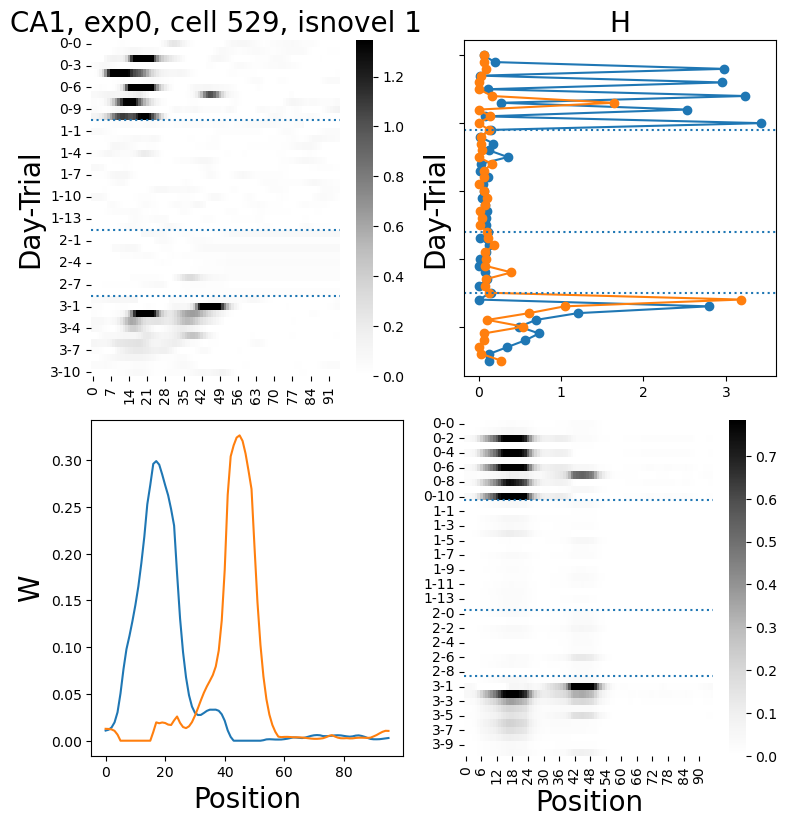

In [191]:
#normal nmf
reload(unmf)
n_components = 2
W_hat_ma,H_hat_ma,X_hat,recon = unmf.do_nmf_wrapper(X_df,n_components=n_components,norm_H=None,norm_W='norm')
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)
# fig,ax=ph.heatmap(X_df_.T)
# ph.plot_day_on_heatmap(X_df_.T,ax=ax)

2
[0.06180551 0.06890108 0.01417455 0.00865064]


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


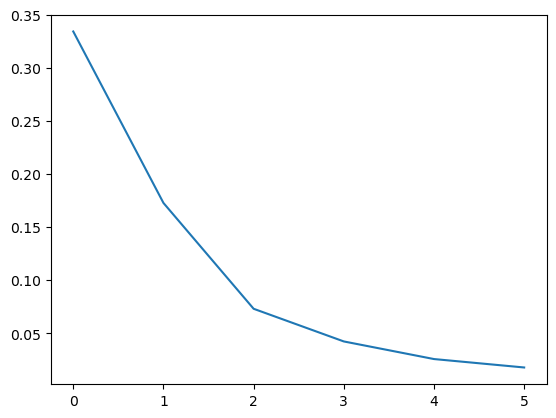

In [196]:
# rank selection
reload(unmf)
ind_selected,recon_l = unmf.pick_nmf_rank_one_neuron(X_df,rank_l=range(1,7))
print(ind_selected)
print(np.diff(np.diff(recon_l)))

plt.plot(recon_l)

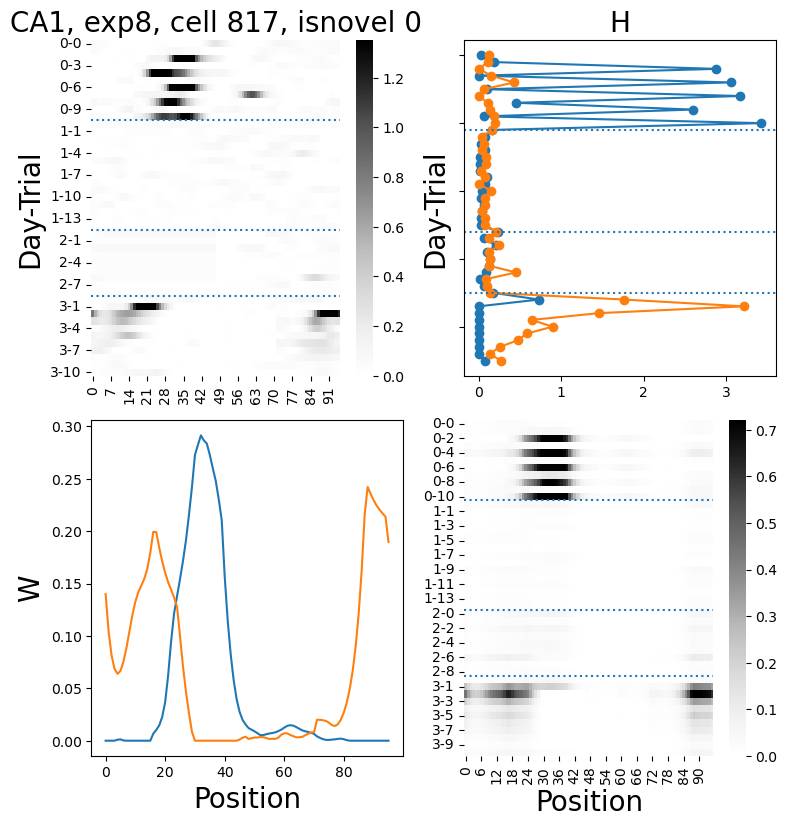

In [100]:
# # one shuffle example
# X_df_null=rba.shuffle_all_day(X_df,min_roll=n_roll_min)
# W_hat_ma_null, H_hat_ma_null,X_hat_null, recon_null = unmf.do_nmf_wrapper(X_df_null,norm_H=None,norm_W='norm')
fig,axs=unmf.plot_ratemap_and_wh(X_df_null,W_hat_ma_null,H_hat_ma_null,X_hat=X_hat_null,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)


In [203]:
reload(rba)
res_one, recon_null_l = rba.nmf_pick_rank_shuffle_one_neuron(X_df,rank_l=range(1,5),nrepeats=1000,alpha=0.05,normalize_error=True)



/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [209]:
import shuffle_nmf_one_exp as snoe
reload(snoe)
reload(unmf)
reload(rba)
snoe.main(0,test_mode=True)

0it [00:00, ?it/s]/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iteration

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

1it [00:08,  8.65s/it]/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of itera

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

saved at /mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/shuffle_nmf_error_mask_True.p


{'summary': 0  0  recon          0.452828
       p              0.019000
       null_mean      0.575444
       null_ci_up     0.650313
       null_ci_low    0.465607
    1  recon          0.496798
       p              0.054000
       null_mean      0.596624
       null_ci_up     0.675983
       null_ci_low    0.483059
    2  recon          0.335782
       p              0.005000
       null_mean      0.379705
       null_ci_up     0.410714
       null_ci_low    0.347223
 dtype: float64,
 'recon_null':             0                    
             0         1         2
 0    0.473018  0.650171  0.376702
 1    0.478530  0.651324  0.411590
 2    0.617991  0.545771  0.406591
 3    0.630220  0.542947  0.408373
 4    0.568121  0.640619  0.375568
 ..        ...       ...       ...
 995  0.581361  0.520224  0.375074
 996  0.594598  0.598695  0.383660
 997  0.612050  0.524191  0.381828
 998  0.556919  0.642725  0.399873
 999  0.594206  0.650889  0.368582
 
 [1000 rows x 3 columns]}

(<Figure size 640x480 with 1 Axes>, <Axes: >)

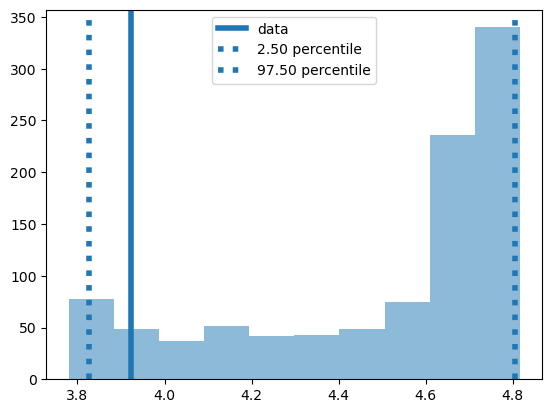

In [180]:
ph.plot_shuffle_data_dist_with_thresh(recon_null_l,res_one['recon'],plot_ci_low=True)

In [170]:
np.quantile(np.random.normal(size=10),0.95)

1.462352207840593

In [165]:
import tqdm
# shuffle do nmf
nrepeats = 1000
n_roll_min=10
H_hat_ma_null_l = []
recon_null_l=[]

H = H_hat_ma
reu_index,two_largest_day = rba.block_reusing_index(H,ntrial_win=5)

for n in tqdm.tqdm(range(nrepeats)):
    X_df_null=rba.shuffle_all_day(X_df,min_roll=n_roll_min)
    W_hat_ma_null, H_hat_ma_null,X_hat_null, recon_null = unmf.do_nmf_wrapper(X_df_null,norm_H=None,norm_W='norm',n_components=n_components)
#     reu_index_null,two_largest_day_null=rba.block_reusing_index(H_hat_ma_null)

    H_hat_ma_null_l.append(H_hat_ma_null)
#     recon_null = loss_history['reconstruction'].iloc[-1]
#     if recon_null < recon:
#         break
    recon_null_l.append(recon_null)
H_hat_ma_null_l = pd.concat(H_hat_ma_null_l,axis=0)


100%|██████████| 1000/1000 [00:06<00:00, 164.91it/s]


In [127]:
recon

1.9539208139175706

(<Figure size 640x480 with 1 Axes>, <Axes: >)

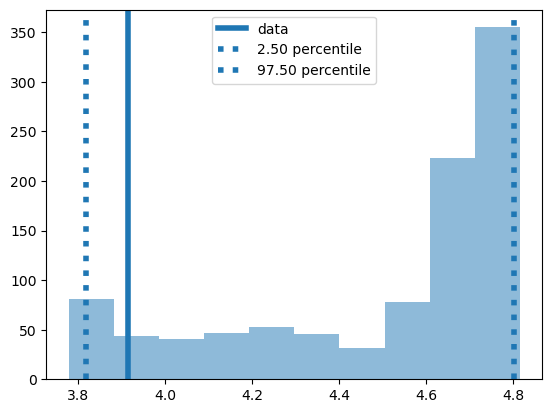

In [166]:
ph.plot_shuffle_data_dist_with_thresh(recon_null_l,recon,plot_ci_low=True)

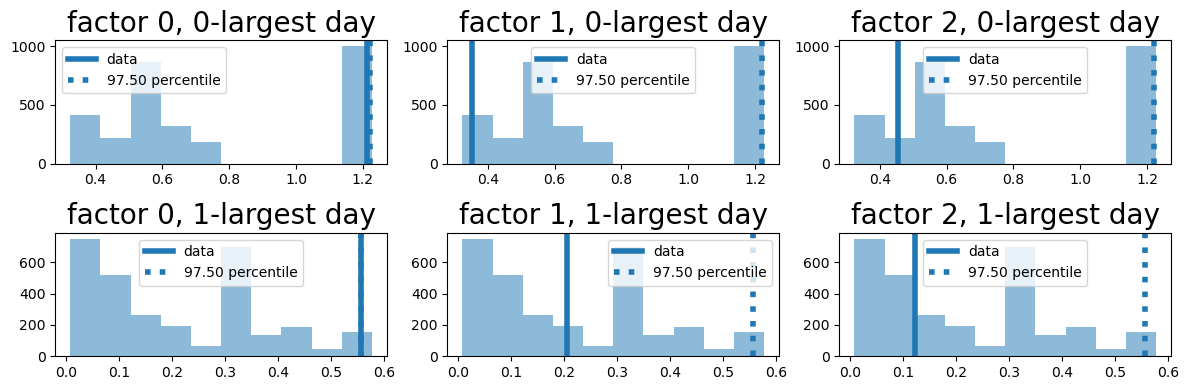

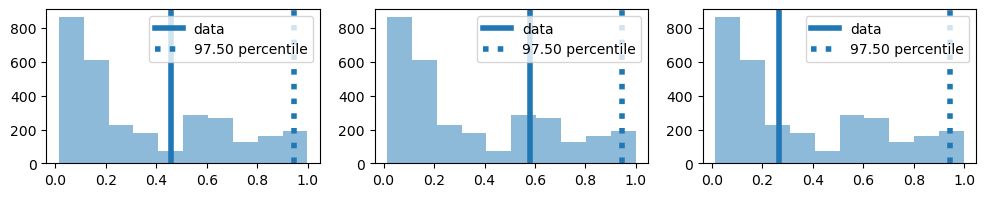

In [124]:
reload(rba)
H = H_hat_ma
method='mean'
ntrial_win = 5
reu_index,two_largest_day = rba.block_reusing_index(H,ntrial_win=ntrial_win,method=method)

reu_index_null,two_largest_day_null=rba.block_reusing_index(H_hat_ma_null_l,ntrial_win=ntrial_win,method=method)

# reusing index distribution, just using second largest day
nplots= H.shape[0]
fig,axs=plt.subplots(2,nplots,figsize=(nplots*4,4))
for kk in range(2):
    for ii in range(H.shape[0]):
        ax=axs[kk,ii]
        fig,ax=ph.plot_shuffle_data_dist_with_thresh(two_largest_day_null[kk],two_largest_day.loc[ii,kk],ax=ax)
        ax.set_title(f'factor {ii}, {kk}-largest day')
plt.tight_layout()

# reusing index distribution, using the ratio
fig,axs=plt.subplots(1,nplots,figsize=(nplots*4,2))
for ii in range(H.shape[0]):
    ax=axs[ii]
    ph.plot_shuffle_data_dist_with_thresh(reu_index_null.values,reu_index.loc[ii],ax=ax)

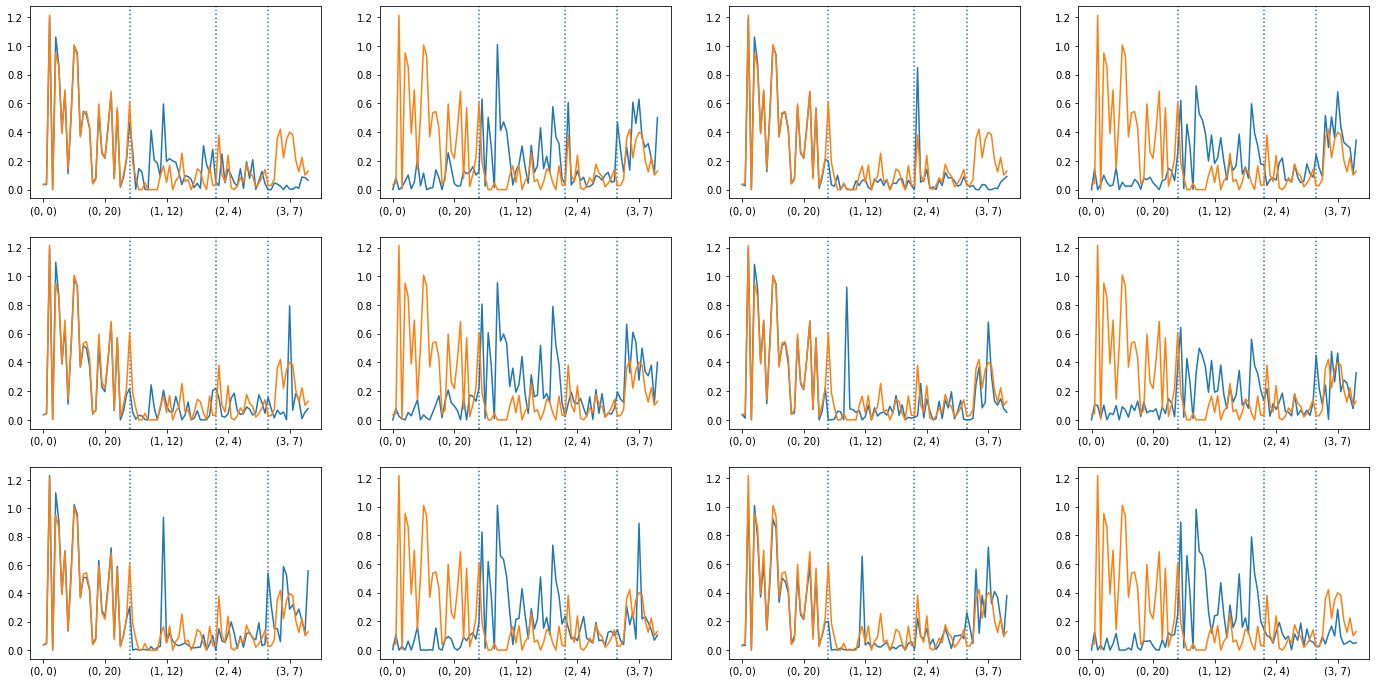

In [452]:
nplots = 12
fig,axs=ph.subplots_wrapper(nplots)
for i in range(nplots):
    ax=axs.ravel()[i]
    ax=H_hat_ma_null_l.iloc[i].plot(ax=ax)
    ph.plot_day_on_heatmap(X_df.T,hline=False,vline=True,ax=ax)
    H_hat_ma.loc[0].plot(ax=ax)

# unimodal nmf

In [530]:
exp_ind=('CA1',slice(None),0)
per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
row=per_cell_metrics_oneexp.query('si>1').sample(1,random_state=3)
print(row)
region, exp, day,isnovel,uid=ind=row.index[0]
# region,exp = exp_ind

# region = 'CA1'#'CA3'
# exp = 0#0
# uid = 64#21
# isnovel = 0#1

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_ = X_df_.fillna(axis=0,method='ffill')
maxval = np.quantile(X_df_.dropna(),0.99)
X_df_[X_df_ > maxval] = X_df_

get_field_day = 3
compare_day = 2

# X_df_compare = X_df_.loc[:,[compare_day]]

# X_df_field = X_df_#X_df_.loc[:,[get_field_day]] # 
X_df_field = X_df_# X_df_.loc[:,X_df_.columns.get_level_values(0)!=2] #
# norm_factor = np.quantile(X_df_field.dropna().values,0.99)
# X_df = X_df_field /norm_factor
X_df = X_df_field

reload(unmf)
n_basis = 20#20
lam_beta=20
lam_beta_cross=20.
# lam_beta=lam_beta_cross = 20.#1.
lam_h = .1 # 0.1
rtol=1e-3
# lam_beta_cross = 10.#0.1
norm_W='mean' # 'max'
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=True,norm_H=None,norm_W=norm_W
                                                               )

recon = loss_history['reconstruction'].iloc[-1]

field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.1)


                     si     fr_cv   mean_fr  sparsity
CA1 5 0 1 364  1.510655  0.573252  0.014409  3.455849
iter0--tot: 279.32602, recon: 56.87762, reg_beta: 1.18336, reg_H: 17.62943, reg_beta_cross: 203.63561
iter1--tot: 513.33055, recon: 35.77853, reg_beta: 3.49327, reg_H: 16.31686, reg_beta_cross: 457.74190
iter2--tot: 484.93586, recon: 35.45087, reg_beta: 3.83328, reg_H: 15.20739, reg_beta_cross: 430.44432
iter3--tot: 492.23984, recon: 35.30498, reg_beta: 3.91794, reg_H: 15.05703, reg_beta_cross: 437.95989
iter4--tot: 494.45098, recon: 35.26682, reg_beta: 3.94462, reg_H: 15.00993, reg_beta_cross: 440.22960
iter5--tot: 495.14444, recon: 35.25523, reg_beta: 3.95302, reg_H: 14.99517, reg_beta_cross: 440.94102
iter6--tot: 495.36188, recon: 35.25162, reg_beta: 3.95564, reg_H: 14.99056, reg_beta_cross: 441.16405
iter7--tot: 495.42983, recon: 35.25050, reg_beta: 3.95646, reg_H: 14.98913, reg_beta_cross: 441.23374
iter8--tot: 495.45101, recon: 35.25015, reg_beta: 3.95671, reg_H: 14.98868, 

(None, <Axes: xlabel='Position'>)

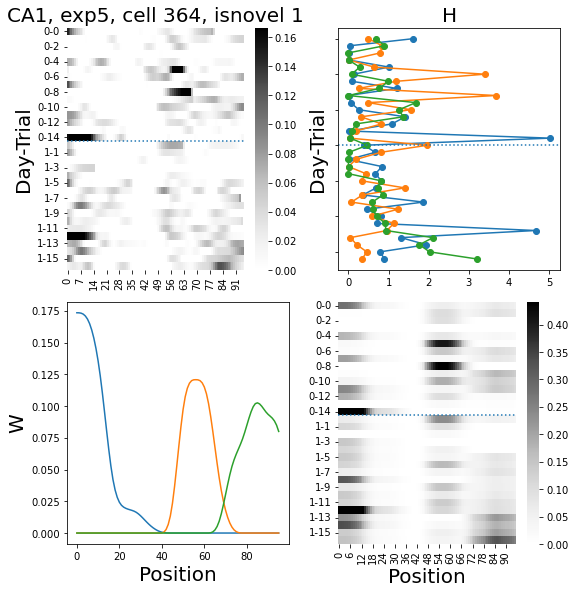

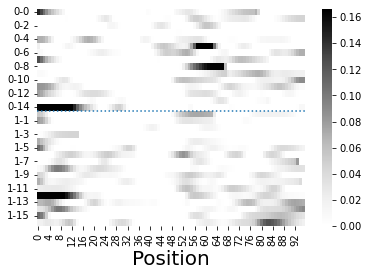

In [531]:
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)
fig,ax=ph.heatmap(X_df_.T)
ph.plot_day_on_heatmap(X_df_.T,ax=ax)

In [525]:
reload(rba)
reload(unmf)

<module 'unimodal_nmf' from '/mnt/home/szheng/projects/nmf_analysis/unimodal_nmf.py'>

In [526]:
import tqdm
# shuffle do nmf
nrepeats = 20
n_roll_min=10
H_hat_ma_null_l = []
recon_null_l=[]
for n in tqdm.tqdm(range(nrepeats)):
    X_df_null=rba.shuffle_all_day(X_df,min_roll=n_roll_min)
    W_hat_ma_null, H_hat_ma_null,X_hat_null, loss_history = unmf.do_unimodal_nmf_wrapper(X_df_null,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=False,norm_H=None,norm_W=norm_W,
                                                               )
    H_hat_ma_null_l.append(H_hat_ma_null)
    recon_null = loss_history['reconstruction'].iloc[-1]
    if recon_null < recon:
        break
    recon_null_l.append(recon_null)
H_hat_ma_null_l = pd.concat(H_hat_ma_null_l,axis=0)


  0%|          | 0/20 [00:00<?, ?it/s]

[75 62 27 49]


  0%|          | 0/20 [00:09<?, ?it/s]

success=True


(None, <Axes: xlabel='Position'>)

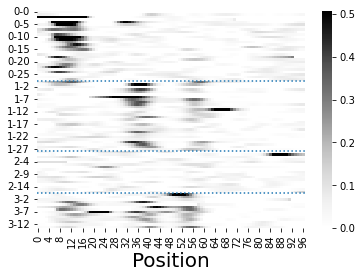

In [527]:
fig,ax=ph.heatmap(X_df.T)
ph.plot_day_on_heatmap(X_df.T,ax=ax)

(None, <Axes: xlabel='Position'>)

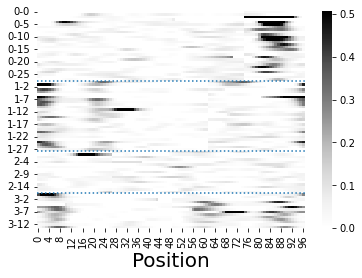

In [528]:
fig,ax=ph.heatmap(X_df_null.T)
ph.plot_day_on_heatmap(X_df_null.T,ax=ax)

In [505]:
recon_null_l

[96.1490997185271]

(<Figure size 432x288 with 1 Axes>, <Axes: >)

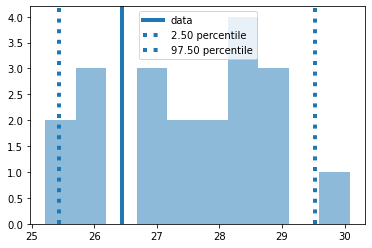

In [477]:
ph.plot_shuffle_data_dist_with_thresh(recon_null_l,recon,plot_ci_low=True)

<Axes: >

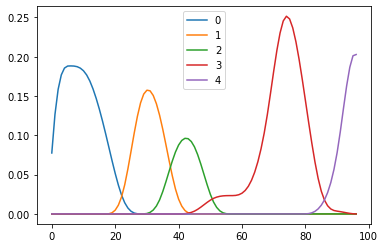

In [512]:
W_hat_ma_null.plot()

In [513]:
H_hat_ma_null_l

0                                                                  \
         0         1             2         3         4         5         6    
0  0.000737  0.127271  1.355483e-06  0.013669  0.023985  0.446266  0.057181   
1  0.128631  0.124449  4.248197e+00  0.000097  3.428087  2.912847  1.342441   
2  0.000001  0.627182  9.305699e-02  0.133977  1.913858  0.650268  0.296338   
0  0.000353  0.595731  3.690959e-01  0.082222  1.118438  0.358817  0.247192   
1  0.000465  0.419077  2.460559e-02  0.119104  0.584822  0.549014  0.054183   
2  0.000033  0.235710  2.449385e-07  0.084973  0.097177  0.511710  0.076449   
3  0.130465  0.141978  4.378236e+00  0.001973  3.388931  3.001346  1.404171   
4  0.000069  0.000056  3.513639e-07  0.000475  2.442554  0.669262  0.268841   

                                     ...             3                      \
             7         8         9   ...            4         5         6    
0  3.807015e-01  0.886777  0.186851  ...  3.790966e-02  0.083803  0.169330   
1  2.351325e+00  0.394154  1.781296  ...  1.436381e+00  0.942143  1.230447   
2  1.106874e-01  0.546635  0.220815  ...  2.454448e-01  2.860738  1.391025   
0  2.054968e-01  0.462546  0.297854  ...  4.103468e-02  3.333673  1.313299   
1  7.761132e-02  0.044083  0.036100  ...  2.117153e-01  0.024137  0.033618   
2  2.838949e-01  0.583368  0.128099  ...  4.471575e-07  0.000001  0.146711   
3  2.443568e+00  0.477047  1.791075  ...  1.469641e+00  0.824532  1.086107   
4  7.827305e-07  0.070756  0.141408  ...  2.126130e-01  0.323252  0.156689   

                                                                             
         7         8         9         10            11        12        13  
0  0.001988  0.000001  0.063762  0.171269  1.946153e-01  0.170311  0.245715  
1  1.603550  1.421918  0.794509  0.558495  8.529632e-01  0.333585  0.538493  
2  2.674205  1.312805  1.350492  1.474931  9.943796e-01  0.453608  2.061967  
0  1.866753  1.182759  0.814326  1.032472  1.029892e+00  0.362648  1.717126  
1  0.050639  0.021510  0.035352  0.044427  5.952217e-07  0.076103  0.068115  
2  0.000003  0.000001  0.021166  0.031339  4.280453e-01  0.425001  0.440406  
3  1.880828  1.370240  0.726956  0.500161  7.650469e-01  0.337124  0.455509  
4  2.731843  0.678977  1.600369  1.286543  4.941439e-01  0.219875  0.877634  

[8 rows x 87 columns]

IndexError: single positional indexer is out-of-bounds

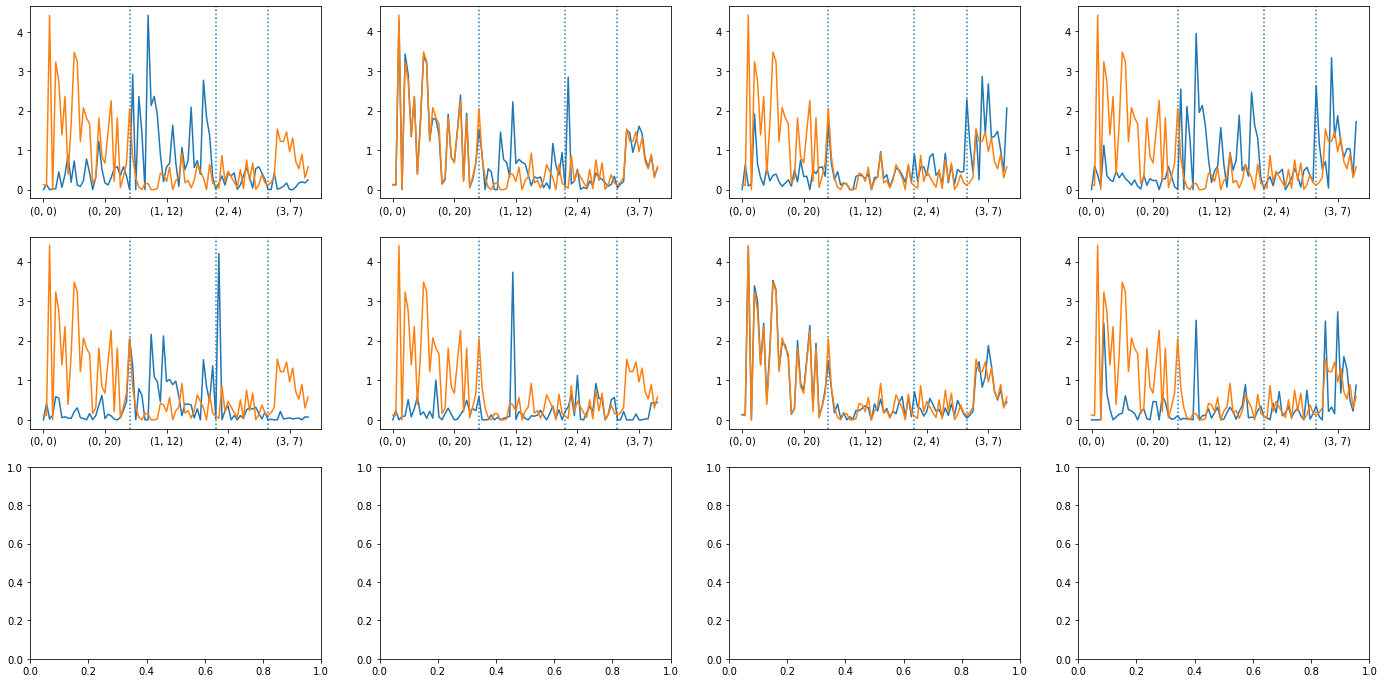

In [509]:
nplots = 12
fig,axs=ph.subplots_wrapper(nplots)
for i in range(nplots):
    ax=axs.ravel()[i]
    ax=H_hat_ma_null_l.iloc[i].plot(ax=ax)
    ph.plot_day_on_heatmap(X_df.T,hline=False,vline=True,ax=ax)
    H_hat_ma.loc[0].plot(ax=ax)

In [201]:
# ntrial_win = 3
# H = H_hat_ma
# H_mov_avg = H.groupby(level=0,axis=1).apply(lambda x:x.rolling(ntrial_win,axis=1).mean())
# # max within day
# max_within_day = H_mov_avg.groupby(level=0,axis=1).max()

# # two largest day
# two_largest_day=max_within_day.apply(lambda x:x.nlargest(2).reset_index(drop=True),axis=1)

# # ratio of second / largest day
# ratio = two_largest_day[1] / two_largest_day[0]

In [418]:
reload(rba)
H = H_hat_ma
reu_index,two_largest_day = rba.block_reusing_index(H,ntrial_win=5)

reu_index_null,two_largest_day_null=rba.block_reusing_index(H_hat_ma_null_l)

# reusing index distribution, just using second largest day
nplots= H.shape[0]
fig,axs=plt.subplots(2,nplots,figsize=(nplots*4,4))
for kk in range(2):
    for ii in range(H.shape[0]):
        ax=axs[kk,ii]
        fig,ax=ph.plot_shuffle_data_dist_with_thresh(two_largest_day_null[kk],two_largest_day.loc[ii,kk],ax=ax)
        ax.set_title(f'factor {ii}, {kk}-largest day')
plt.tight_layout()

# reusing index distribution, using the ratio
ph.plot_shuffle_data_dist_with_thresh(reu_index_null.values,reu_index.loc[3])

iter0--tot: 878.50776, recon: 153.07613, reg_beta: 1.25237, reg_H: 46.73787, reg_beta_cross: 677.44139
iter1--tot: 1116.09373, recon: 91.95128, reg_beta: 5.91333, reg_H: 37.47067, reg_beta_cross: 980.75845
iter2--tot: 1201.54349, recon: 88.05849, reg_beta: 6.91517, reg_H: 36.25007, reg_beta_cross: 1070.31977
iter3--tot: 1227.52045, recon: 87.24279, reg_beta: 7.12456, reg_H: 35.74698, reg_beta_cross: 1097.40612
iter4--tot: 1241.27996, recon: 86.90476, reg_beta: 7.18541, reg_H: 35.57766, reg_beta_cross: 1111.61212
iter5--tot: 1248.03794, recon: 86.70166, reg_beta: 7.22528, reg_H: 35.50777, reg_beta_cross: 1118.60323
iter6--tot: 1251.80633, recon: 86.61371, reg_beta: 7.24032, reg_H: 35.46511, reg_beta_cross: 1122.48719
iter7--tot: 1253.52942, recon: 86.58460, reg_beta: 7.25116, reg_H: 35.43677, reg_beta_cross: 1124.25689
iter8--tot: 1254.31231, recon: 86.57434, reg_beta: 7.25659, reg_H: 35.42135, reg_beta_cross: 1125.06002
iter9--tot: 1254.67740, recon: 86.57016, reg_beta: 7.25913, reg_H:

(None, <Axes: xlabel='Position'>)

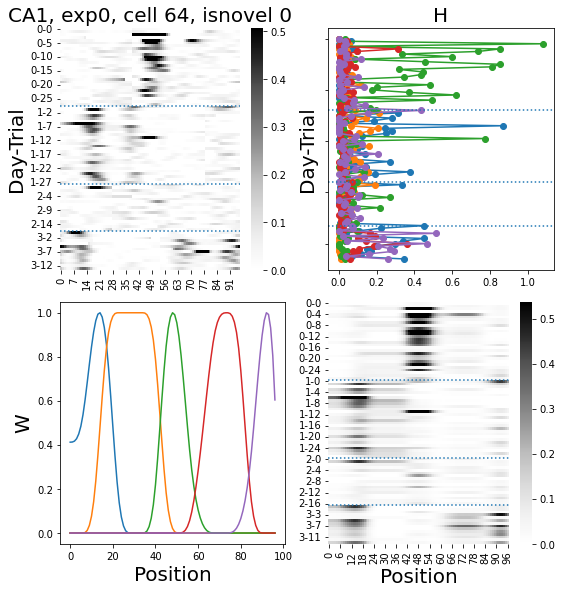

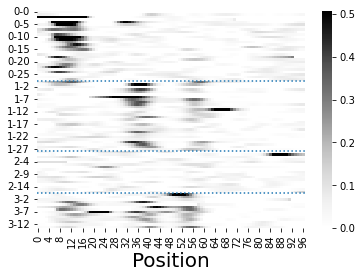

In [431]:
n_roll_min=10
X_df_null=rba.shuffle_all_day(X_df,min_roll=n_roll_min)
W_hat_ma_null, H_hat_ma_null,X_hat_null, loss_history = unmf.do_unimodal_nmf_wrapper(X_df_null,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=1e-3,
                                                                verbose=True,norm_H=None,norm_W='max',
                                                               )
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df_null,W_hat_ma_null,H_hat_ma_null,X_hat=X_hat_null,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)
fig,ax=ph.heatmap(X_df_.T)
ph.plot_day_on_heatmap(X_df_.T,ax=ax)
    

In [317]:
H_hat_ma.loc[0]

0  0     0.041715
   1     0.054197
   2     4.868856
   3     0.001333
   4     1.688276
           ...   
3  9     0.148515
   10    0.128432
   11    0.205102
   12    0.054342
   13    0.153014
Name: 0, Length: 87, dtype: float64

In [361]:
H_hat_ma.loc[0].groupby(level=0).apply(lambda x:x.rolling(3).mean()).max()

0.5904512203814475

In [427]:
H_hat_ma_null_l

0                                                      \
              0             1             2         3             4    
0   8.627757e-05  1.854138e-07  1.155344e-01  0.000084  1.280844e-08   
1   7.785873e-05  2.365018e-02  1.206499e-02  0.000121  5.966044e-01   
2   5.783619e-05  5.981075e-02  3.142866e-02  0.021547  7.384786e-02   
3   6.580932e-04  1.818836e-02  8.087190e-03  0.000177  1.870603e-03   
4   3.150288e-02  3.319653e-02  1.028640e+00  0.000561  8.090599e-01   
..           ...           ...           ...       ...           ...   
0   6.874477e-05  5.722971e-02  3.562686e-02  0.002133  5.227889e-01   
1   2.862740e-05  2.601180e-02  8.835497e-03  0.011867  2.679846e-02   
2   3.632158e-07  2.111310e-02  1.778616e-08  0.002490  1.162007e-02   
3   1.986032e-02  6.508740e-02  3.341363e-01  0.001555  3.856940e-02   
4   2.668409e-02  9.039633e-03  1.044018e+00  0.000047  9.070148e-01   

                                                                  ...  \
              5             6         7         8             9   ...   
0   3.549347e-08  3.965452e-02  0.043610  0.002307  1.165729e-07  ...   
1   1.924733e-01  7.090480e-02  0.005758  0.024720  9.643305e-02  ...   
2   4.596075e-02  2.346810e-02  0.035240  0.075693  4.844950e-03  ...   
3   6.971390e-02  1.025341e-02  0.065325  0.115921  2.870779e-02  ...   
4   6.937134e-01  3.198160e-01  0.569730  0.096580  4.230152e-01  ...   
..           ...           ...       ...       ...           ...  ...   
0   1.627233e-01  6.208236e-02  0.015619  0.039596  8.346413e-02  ...   
1   2.402954e-02  1.017914e-02  0.011417  0.022134  1.632906e-04  ...   
2   8.638369e-02  1.148691e-02  0.056865  0.138268  3.059287e-02  ...   
3   8.168930e-02  2.152402e-08  0.168963  0.043453  7.555778e-02  ...   
4   7.747874e-01  3.878318e-01  0.584857  0.096256  4.460355e-01  ...   

               3                                                            \
              4             5             6         7         8         9    
0   3.438556e-01  1.927498e-01  2.619596e-01  0.091024  0.314668  0.150100   
1   9.061902e-02  2.970049e-08  7.229699e-08  0.679961  0.086342  0.124338   
2   1.632241e-02  5.281447e-01  2.547099e-01  0.362682  0.226924  0.182811   
3   4.139914e-03  9.706025e-04  1.308424e-02  0.003875  0.002907  0.005987   
4   1.660571e-02  1.955561e-01  1.334372e-01  0.046913  0.056910  0.059078   
..           ...           ...           ...       ...       ...       ...   
0   1.245311e-02  2.377384e-03  4.639271e-03  0.003894  0.002724  0.006853   
1   4.401305e-02  7.259048e-02  7.318830e-02  0.003276  0.050902  0.030991   
2   1.594196e-01  1.962220e-02  5.324096e-02  0.611936  0.149017  0.136144   
3   2.697853e-07  3.499991e-01  1.254374e-02  0.315341  0.160173  0.147324   
4   1.077478e-02  5.911188e-01  3.770798e-01  0.319229  0.216156  0.179748   

                                            
          10        11        12        13  
0   0.079759  0.191742  0.063122  0.109083  
1   0.098237  0.011831  0.040466  0.025670  
2   0.221121  0.177663  0.067964  0.339392  
3   0.005400  0.037088  0.041166  0.044614  
4   0.070389  0.069579  0.015862  0.063879  
..       ...       ...       ...       ...  
0   0.007030  0.026468  0.036774  0.038577  
1   0.029600  0.043301  0.012222  0.032840  
2   0.099753  0.052574  0.050624  0.046145  
3   0.210173  0.156728  0.019763  0.205938  
4   0.167331  0.165044  0.093048  0.341826  

[108 rows x 87 columns]

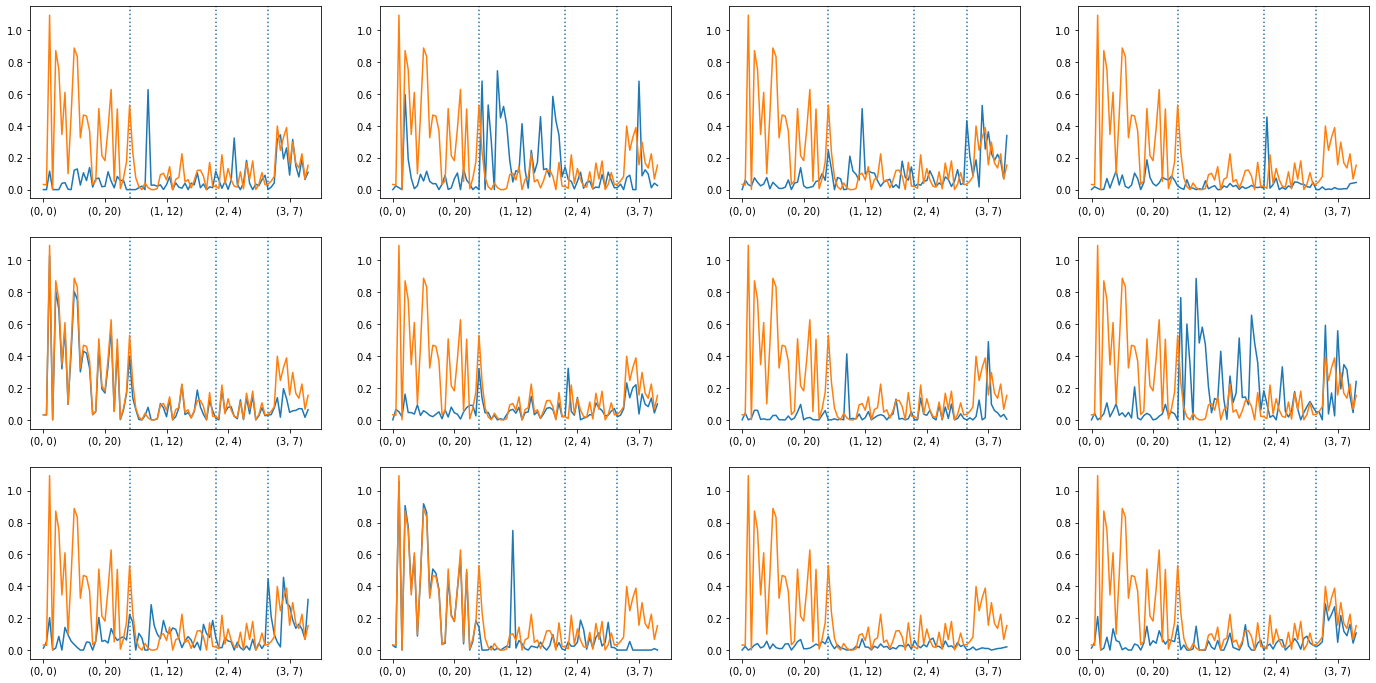

In [430]:
nplots = 12
fig,axs=ph.subplots_wrapper(nplots)
for i in range(nplots):
    ax=axs.ravel()[i]
    ax=H_hat_ma_null_l.iloc[i].plot(ax=ax)
    ph.plot_day_on_heatmap(X_df.T,hline=False,vline=True,ax=ax)
    H_hat_ma.loc[0].plot(ax=ax)

In [135]:
# field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2)
field_range=rba.get_field(W_hat_ma_null,extend=2,max_thresh=0.2)
print(field_range)

   start  end  window_start  window_end
0      1   45             0          67
1     84   96            72          96


In [136]:
reload(rba)
pre_day_activation = rba.get_activation_all_field(X_df_compare,field_range)
diff_null_l = rba.circular_shuffle_get_null_activation_all_field(X_df_compare,field_range,n_roll_min = 10,nrepeats = 1000)


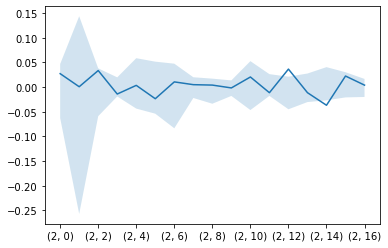

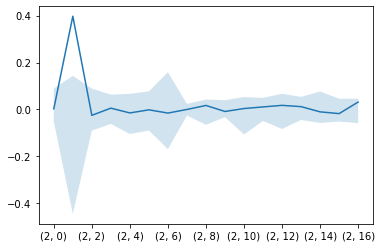

In [138]:
alpha=0.001
up=diff_null_l.groupby(level=0).quantile(1-alpha)
low=diff_null_l.groupby(level=0).quantile(alpha)
for i in range(low.shape[0]):
    plt.figure()
    ax=pre_day_activation.loc['diff',i].plot()
    ax.fill_between(np.arange(low.shape[1]),low.loc[i],up.loc[i],alpha=0.2)

In [86]:
diff_null_l

2                                                              \
          0         1         2         3         4         5         6    
0  -0.010151  0.259158 -0.029513 -0.003584 -0.048664  0.000000  0.006446   
1   0.002943  0.025640  0.021218 -0.009812  0.058833 -0.024775 -0.039128   
2   0.024899 -0.108639  0.035573 -0.018207 -0.026271  0.020299  0.052701   
0   0.021434 -0.015263 -0.013676  0.053798 -0.009846 -0.038726 -0.058246   
1  -0.022234 -0.002833  0.004487 -0.023642 -0.022114  0.053072  0.031300   
..       ...       ...       ...       ...       ...       ...       ...   
1  -0.003455 -0.065723  0.012119 -0.004269 -0.005646 -0.040594 -0.018460   
2  -0.034749  0.145989  0.022539  0.000896  0.024229 -0.014083 -0.061941   
0   0.068949  0.044115 -0.010148 -0.005012 -0.039946  0.011256  0.100244   
1   0.010118 -0.016357  0.006087  0.016034  0.017904 -0.034263 -0.124255   
2  -0.028980 -0.173447  0.006547  0.009380 -0.000522  0.020552  0.027462   

                                                                          \
          7         8         9         10        11        12        13   
0  -0.005498 -0.028019 -0.025938 -0.037557  0.000400  0.011703  0.025357   
1   0.008552  0.003281  0.011401  0.013839  0.025363  0.022626 -0.009943   
2  -0.001055  0.012102 -0.001322  0.015824 -0.017235  0.020174  0.003718   
0   0.013749 -0.018938  0.003520 -0.001673 -0.037428 -0.015707 -0.022215   
1  -0.009282  0.021410  0.013443  0.014393  0.031929 -0.009373  0.035245   
..       ...       ...       ...       ...       ...       ...       ...   
1  -0.000709 -0.029379  0.013338 -0.014971 -0.015732 -0.003763  0.018478   
2  -0.004244  0.025343 -0.017127  0.001601  0.009568  0.043130 -0.015727   
0  -0.004678 -0.006047  0.018410  0.019680  0.022805 -0.055587  0.014381   
1   0.009455 -0.010724 -0.016275 -0.047115 -0.045479  0.027514 -0.016909   
2  -0.004661 -0.004442  0.011827  0.014520  0.011010 -0.031217  0.009774   

                                  
          14        15        16  
0   0.012221 -0.019798 -0.048044  
1  -0.004910  0.030817  0.014511  
2  -0.001916  0.022349 -0.013787  
0  -0.024025 -0.004164  0.025987  
1   0.057850  0.011081 -0.001057  
..       ...       ...       ...  
1  -0.006861  0.016666 -0.016314  
2  -0.026752 -0.015918  0.000436  
0   0.037010  0.037386  0.002323  
1  -0.024628 -0.016318 -0.005224  
2   0.026197  0.009248 -0.007177  

[3000 rows x 17 columns]

In [311]:
def get_activation_all_field(X_df_compare,field_range):
    pre_day_activation = {}
    for field_id,row in field_range.iterrows():
        pre_day_activation_per_field = {}
        ma_full = (X_df_compare.index>=row['window_start'])&(X_df_compare.index<=row['window_end'])
        ma_field = (X_df_compare.index>=row['start'])&(X_df_compare.index<=row['end'])
        outside = ma_full & np.logical_not(ma_field)
        pre_day_activation_per_field['within'] = X_df_compare.loc[ma_field].mean(axis=0)
        pre_day_activation_per_field['outside'] = X_df_compare.loc[outside].mean(axis=0)
        pre_day_activation_per_field['diff'] = pre_day_activation_per_field['within'] - pre_day_activation_per_field['outside']
        pre_day_activation_per_field = pd.concat(pre_day_activation_per_field,axis=1)
        pre_day_activation[field_id] = pre_day_activation_per_field.T
    pre_day_activation = pd.concat(pre_day_activation,axis=0).swaplevel(0,1)
    return pre_day_activation

In [312]:
n_roll_min = 10
n_pos = X_df_compare.shape[0]
nrepeats = 1000
diff_null_l=[]
for n in range(nrepeats):
    nn=np.random.randint(n_roll_min,n_pos-n_roll_min)
    X_df_compare_null=pd.DataFrame(np.roll(X_df_compare,nn,axis=0),index=X_df_compare.index,columns=X_df_compare.columns)
    diff_null = get_activation_all_field(X_df_compare_null,field_range).loc['diff']
    diff_null_l.append(diff_null)
diff_null_l = pd.concat(diff_null_l,axis=0)

In [313]:
pre_day_activation = {}
for field_id,row in field_range.iterrows():
    pre_day_activation_per_field = {}
    ma_full = (X_df_compare.index>=row['window_start'])&(X_df_compare.index<=row['window_end'])
    ma_field = (X_df_compare.index>=row['start'])&(X_df_compare.index<=row['end'])
    outside = ma_full & np.logical_not(ma_field)
    pre_day_activation_per_field['within'] = X_df_compare.loc[ma_field].mean(axis=0)
    pre_day_activation_per_field['outside'] = X_df_compare.loc[outside].mean(axis=0)
    pre_day_activation_per_field['diff'] = pre_day_activation_per_field['within'] - pre_day_activation_per_field['outside']
    pre_day_activation_per_field = pd.concat(pre_day_activation_per_field,axis=1)
    pre_day_activation[field_id] = pre_day_activation_per_field.T
pre_day_activation = pd.concat(pre_day_activation,axis=0).swaplevel(0,1)

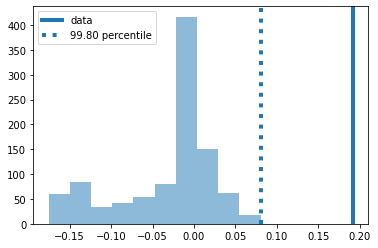

In [314]:
nfields = field_range.shape[0]
for i in range(nfields):
    row=pre_day_activation.loc[('diff',i),:]
    idx=row.idxmax()
    val = row.loc[idx]
    distr = diff_null_l.loc[i,idx]
    ph.plot_shuffle_data_dist_with_thresh(distr,val,alpha=0.002)

In [260]:
diff_null_l.loc[i,idx]

2    0.020193
2   -0.009236
2   -0.022358
2    0.009829
2    0.015070
2    0.014926
2   -0.023908
2    0.021910
2    0.015351
2    0.007781
Name: (0, 25), dtype: float64

In [256]:
pre_day_activation.loc[('diff',i),:]

0  0     0.000000
   1     0.022670
   2    -0.013331
   3     0.000005
   4     0.009104
   5     0.008292
   6     0.009530
   7    -0.012782
   8     0.001236
   9    -0.004756
   10   -0.005832
   11   -0.008705
   12   -0.005731
   13    0.003490
   14   -0.001045
   15   -0.003938
   16    0.007339
   17   -0.003564
   18   -0.117591
   19   -0.026483
   20   -0.175975
   21   -0.145120
   22   -0.152317
   23   -0.014923
   24   -0.018917
   25    0.042596
   26   -0.001649
   27   -0.041476
Name: (diff, 2), dtype: float64

In [255]:
pre_day_activation.loc[('diff',i),:].max()

0.042596141146253916

In [305]:
alpha=0.002
up=diff_null_l.groupby(level=0).quantile(1-alpha)
low=diff_null_l.groupby(level=0).quantile(alpha)

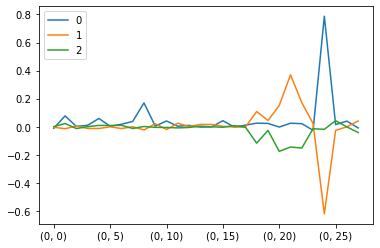

In [307]:
ax=pre_day_activation.loc['diff'].T.plot()

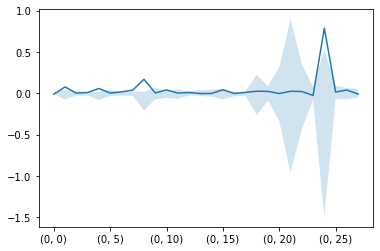

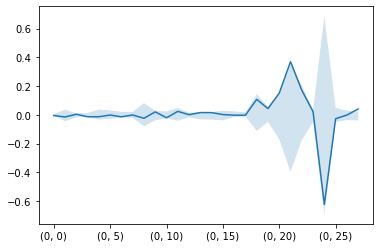

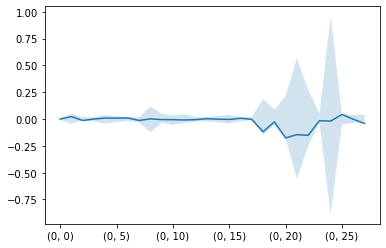

In [306]:
# ax=pre_day_activation.loc['diff'].T.plot()
for i in range(low.shape[0]):
    plt.figure()
    ax=pre_day_activation.loc['diff',i].plot()
    ax.fill_between(np.arange(low.shape[1]),low.loc[i],up.loc[i],alpha=0.2)

In [121]:
pre_day_activation

0                                                    \
                 0         1         2         3         4         5    
0 within   0.000000  0.194403  0.000000  0.000000  0.161904  0.011972   
  outside  0.000000  0.114705  0.000000  0.002664  0.151667  0.000000   
  diff     0.000000  0.079698  0.000000 -0.002664  0.010236  0.011972   
1 within   0.010384  0.023298  0.003758  0.029121  0.020338  0.000000   
  outside  0.004350  0.079894  0.000163  0.000154  0.082487  0.003991   
  diff     0.006034 -0.056595  0.003595  0.028967 -0.062150 -0.003991   
2 within   0.000000  0.006580  0.010077  0.002018  0.002077  0.026137   
  outside  0.000000  0.031371  0.004986  0.003659  0.010925  0.011787   
  diff     0.000000 -0.024791  0.005091 -0.001641 -0.008847  0.014350   
3 within   0.000000  0.045768  0.000000  0.004988  0.019050  0.047461   
  outside  0.000000  0.016748  0.000000  0.004390  0.000000  0.013707   
  diff     0.000000  0.029020  0.000000  0.000598  0.019050  0.033754   

                                                   ...                      \
                 6         7         8         9   ...        18        19   
0 within   0.055859  0.054504  0.449035  0.054567  ...  0.031223  0.065533   
  outside  0.042717  0.048204  0.264538  0.049429  ...  0.027392  0.019592   
  diff     0.013141  0.006300  0.184496  0.005138  ...  0.003830  0.045940   
1 within   0.024910  0.019662  0.056456  0.007491  ...  0.016755  0.004366   
  outside  0.033356  0.023634  0.200065  0.041177  ...  0.013516  0.025053   
  diff    -0.008446 -0.003972 -0.143609 -0.033686  ...  0.003239 -0.020687   
2 within   0.001852  0.015679  0.018530  0.015964  ...  0.199990  0.077850   
  outside  0.004248  0.009119  0.006305  0.059735  ...  0.119217  0.048805   
  diff    -0.002395  0.006560  0.012225 -0.043771  ...  0.080773  0.029045   
3 within   0.013527  0.000174  0.005871  0.036824  ...  0.047332  0.034521   
  outside  0.002952  0.006433  0.002883  0.057048  ...  0.093114  0.051887   
  diff     0.010575 -0.006259  0.002988 -0.020224  ... -0.045782 -0.017366   

                                                                       \
                 20        21        22        23        24        25   
0 within   0.034791  0.043551  0.027542  0.000000  0.056877  0.000000   
  outside  0.006209  0.050760  0.029729  0.008822  0.400595  0.037564   
  diff     0.028582 -0.007209 -0.002186 -0.008822 -0.343718 -0.037564   
1 within   0.001159  0.010328  0.021114  0.032805  1.587291  0.034663   
  outside  0.019305  0.020128  0.013177  0.023493  0.154576  0.015766   
  diff    -0.018146 -0.009800  0.007937  0.009312  1.432715  0.018896   
2 within   0.257505  0.914517  0.398297  0.094047  0.096876  0.020003   
  outside  0.121954  0.047707  0.073196  0.001882  0.043905  0.023780   
  diff     0.135552  0.866810  0.325101  0.092165  0.052971 -0.003777   
3 within   0.012420  0.018211  0.043978  0.019837  0.000421  0.094922   
  outside  0.079114  0.053980  0.057562  0.001170  0.011067  0.027917   
  diff    -0.066695 -0.035770 -0.013585  0.018667 -0.010647  0.067006   

                               
                 26        27  
0 within   0.048549  0.023070  
  outside  0.038968  0.011769  
  diff     0.009580  0.011300  
1 within   0.025625  0.001310  
  outside  0.020879  0.020217  
  diff     0.004746 -0.018907  
2 within   0.015545  0.058302  
  outside  0.040156  0.036471  
  diff    -0.024611  0.021832  
3 within   0.016958  0.003576  
  outside  0.047495  0.011069  
  diff    -0.030537 -0.007492  

[12 rows x 28 columns]

In [111]:
row

start           45
end             55
window_start    40
window_end      60
Name: 3, dtype: int64

In [106]:
field_range

,start,end,window_start,window_end
0,0,2,0,4
1,4,15,0,20
2,27,38,22,43
3,45,55,40,60


(None, <Axes: xlabel='Position'>)

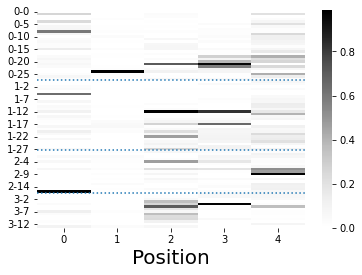

In [53]:
fig,ax=ph.heatmap(H_hat_ma.T)
ph.plot_day_on_heatmap(H_hat_ma.T,ax=ax)

In [42]:
def shuffle_all_day(X_df,min_roll=10):
    gpb=X_df.groupby(axis=1,level=0)
    npos = X_df.shape[0]
    index,col=X_df.index,X_df.columns
    X_df_null = []
    for d,val in gpb:
        n = np.random.randint(min_roll,npos-min_roll)
        X_df_null.append(np.roll(val,n,axis=0))
    X_df_null=np.concatenate(X_df_null,axis=1)
    X_df_null = pd.DataFrame(X_df_null,index=index,columns=col)
    return X_df_null

In [43]:
X_df_null = shuffle_all_day(X_df,min_roll=10)

iter0--tot: 401.74128, recon: 307.67566, reg_beta: 0.25740, reg_H: 75.57498, reg_beta_cross: 18.23324
iter1--tot: 221.22862, recon: 117.22740, reg_beta: 2.53221, reg_H: 45.51420, reg_beta_cross: 55.95481
iter2--tot: 190.47418, recon: 100.91127, reg_beta: 2.68203, reg_H: 39.41268, reg_beta_cross: 47.46819
iter3--tot: 185.06661, recon: 97.63105, reg_beta: 2.64592, reg_H: 36.21567, reg_beta_cross: 48.57398
iter4--tot: 182.68089, recon: 95.92496, reg_beta: 2.62632, reg_H: 34.39179, reg_beta_cross: 49.73782
iter5--tot: 180.29480, recon: 93.24648, reg_beta: 2.65885, reg_H: 33.71496, reg_beta_cross: 50.67451
iter6--tot: 177.98968, recon: 90.16603, reg_beta: 2.72373, reg_H: 33.11140, reg_beta_cross: 51.98851
iter7--tot: 177.68768, recon: 90.05361, reg_beta: 2.74185, reg_H: 32.15844, reg_beta_cross: 52.73378
iter8--tot: 177.58207, recon: 89.96671, reg_beta: 2.75950, reg_H: 31.45878, reg_beta_cross: 53.39707
iter9--tot: 177.55139, recon: 89.89694, reg_beta: 2.77370, reg_H: 30.94521, reg_beta_cro

(None, <Axes: xlabel='Position'>)

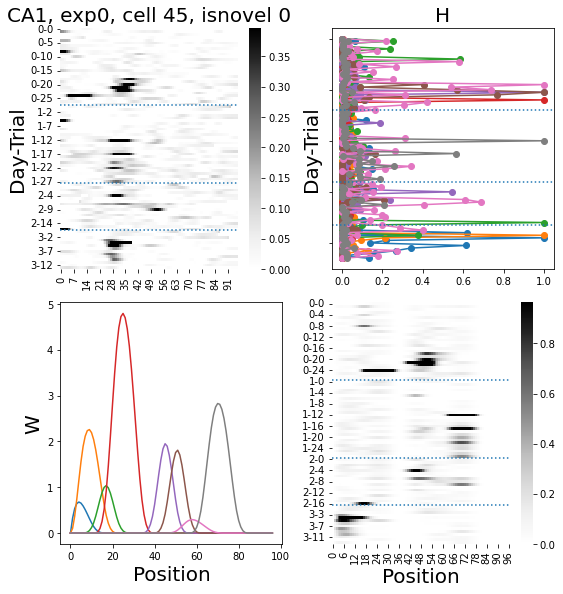

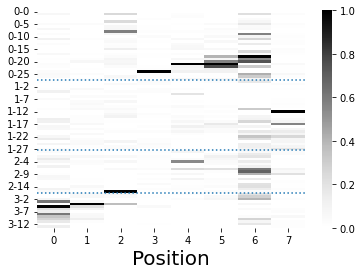

In [54]:
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df_null,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=1e-5,
                                                                verbose=True,
                                                               )


(None, <Axes: xlabel='Position'>)

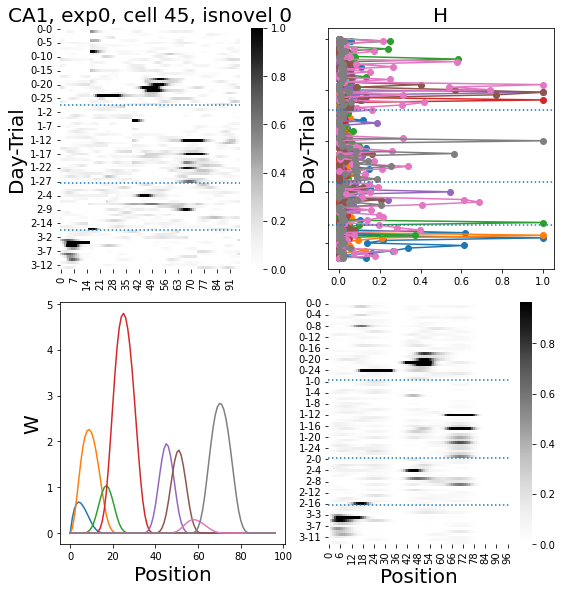

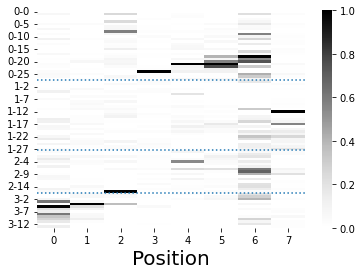

In [55]:
fig,axs=unmf.plot_ratemap_and_wh(X_df_null,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)
fig,ax=ph.heatmap(H_hat_ma.T)
ph.plot_day_on_heatmap(H_hat_ma.T,ax=ax)

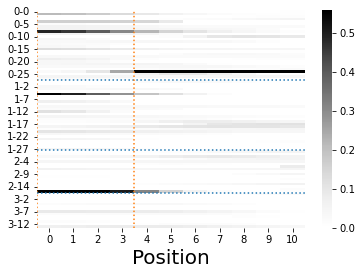

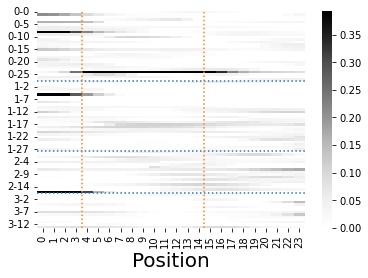

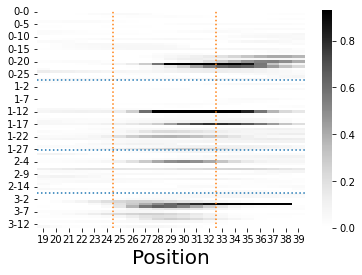

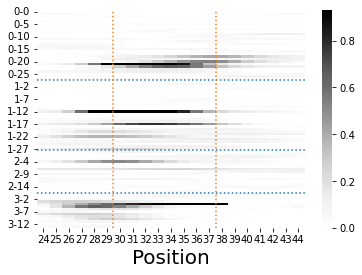

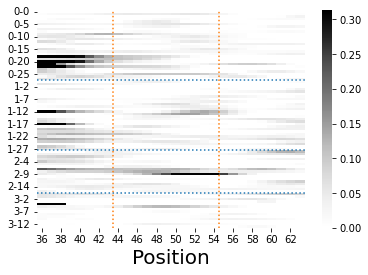

In [36]:
field_range=get_field(W_hat_ma,extend=2.5)
corr_per_field = {}
for ii,fr in field_range.iterrows():

#     X_comb = pd.concat([X_df_compare,X_df_field],axis=1)
    X_comb = X_df_field
    fig,ax=ph.heatmap(X_comb.loc[fr['window_start']:fr['window_end'],:].T)
    ph.plot_day_on_heatmap(X_comb.T,ax=ax)
    ax.axvline(fr['start']-fr['window_start'],c='C1',linestyle=':')
    ax.axvline(fr['end']-fr['window_start'],c='C1',linestyle=':')



In [8]:
# per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
# row=per_cell_metrics_oneexp.query('si>1').sample(1)
# print(row)
# day,isnovel,uid=ind=row.index[0]
# region,exp = exp_ind

region = 'CA1'#'CA3'
exp = 7#0
uid = 375#21
isnovel = 0#1

X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
# X = X_df.fillna(0).values

In [9]:
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_ = X_df_.fillna(axis=0,method='ffill')
maxval = np.quantile(X_df_.dropna(),0.99)
X_df_[X_df_ > maxval] = X_df_
X_df_ = X_df_.loc[:,[2]]
# eps=10e-10
# X_df_[X_df_<0] = eps
# X_df_ = np.log(X_df_)
# X_df_ = X_df_ + X_df_.min().min()
norm_factor = np.quantile(X_df_.dropna().values,0.99)
X_df = X_df_ /norm_factor
# (X_df.max().max()*0.9)

In [10]:
reload(unmf)
n_basis = 20
lam_beta=lam_beta_cross = 1.#1.
lam_h = .1 # 0.1
# lam_beta_cross = 10.#0.1
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=1e-5,
                                                                verbose=True,
                                                               )

iter0--tot: 27.43785, recon: 13.42032, reg_beta: 0.34386, reg_H: 6.12669, reg_beta_cross: 7.54698
iter1--tot: 26.46080, recon: 7.22221, reg_beta: 0.46902, reg_H: 6.30305, reg_beta_cross: 12.46653
iter2--tot: 26.36664, recon: 7.08685, reg_beta: 0.45284, reg_H: 6.47225, reg_beta_cross: 12.35469
iter3--tot: 26.32132, recon: 7.07170, reg_beta: 0.44718, reg_H: 6.52989, reg_beta_cross: 12.27255
iter4--tot: 26.30609, recon: 7.06895, reg_beta: 0.44526, reg_H: 6.54889, reg_beta_cross: 12.24299
iter5--tot: 26.30113, recon: 7.06818, reg_beta: 0.44461, reg_H: 6.55517, reg_beta_cross: 12.23317
iter6--tot: 26.29951, recon: 7.06792, reg_beta: 0.44439, reg_H: 6.55728, reg_beta_cross: 12.22993
iter7--tot: 26.29897, recon: 7.06781, reg_beta: 0.44431, reg_H: 6.55800, reg_beta_cross: 12.22884
iter8--tot: 26.29878, recon: 7.06777, reg_beta: 0.44428, reg_H: 6.55826, reg_beta_cross: 12.22847
success=True


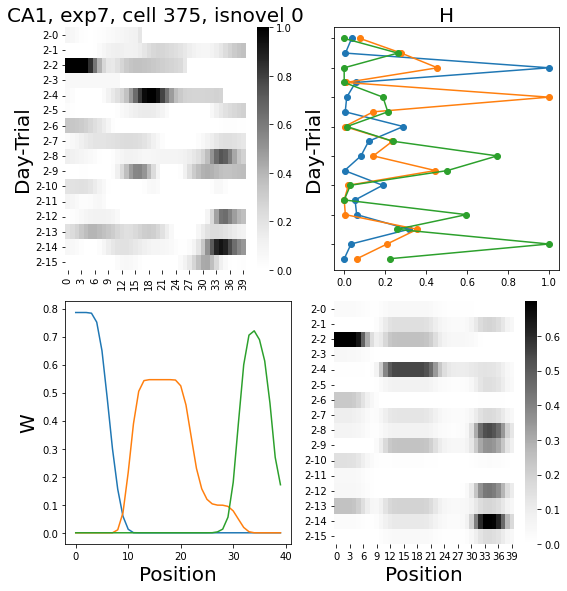

In [11]:
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)

In [21]:
field_range=get_field(W_hat_ma,extend=2)

In [14]:
corr_per_field = {}
for ii,fr in field_range.iterrows():
    corr = np.nanmedian(X_df.loc[fr['start']:fr['end'],:].corr().values.flatten())
    corr_per_field[ii] = corr

In [15]:
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_ = X_df_.fillna(axis=0,method='ffill')
maxval = np.quantile(X_df_.dropna(),0.99)
X_df_[X_df_ > maxval] = X_df_
X_df_oneday = X_df_.loc[:,[0]]


In [16]:
def get_activation_per_day_field(X_df_oneday,w=None,field_range=None):
    '''
    either use w (after normalize to sum to 1) or field_range (mean)
    X_df_oneday: npos x ntrials
    '''
    if w is not None:
        w_norm = w / w.sum()
        activation = (X_df_oneday * w_norm.values[:,None]).sum(axis=0)
    elif field_range is not None:
        pass
    
    return activation
    
    
    
    

In [17]:
def shuffle_get_activation_per_day_field(X_df_oneday,X_df_oneday_null=None,w=None,field_range=None,min_roll=10,nrepeats=100):
    nrow,ncol = X_df_oneday.shape
    ind,col=X_df_oneday.index,X_df_oneday.columns
    X_df_oneday_v = X_df_oneday.values
    if X_df_oneday_null is None:
        X_df_oneday_null = np.concatenate([np.roll(X_df_oneday_v,nn,axis=1) for nn in np.random.randint(min_roll, nrow-min_roll,size=nrepeats)],axis=1)
    
    activation_null = get_activation_per_day_field(X_df_oneday_null,w=w,field_range=field_range)
    activation_null_reshaped = activation_null.reshape(-1,ncol)
    activation_null_reshaped = pd.DataFrame(activation_null_reshaped,columns=col)
    
    return activation_null_reshaped
    

In [299]:
nrepeats = 10
nrow,ncol = X_df_oneday.shape
min_roll=10
X_df_oneday_v = X_df_oneday.values
X_df_oneday_null = np.concatenate([np.roll(X_df_oneday_v,nn,axis=1) for nn in np.random.randint(min_roll, nrow-min_roll,size=nrepeats)],axis=1)




In [ ]:
field_range=get_field(W_hat_ma,extend=2)

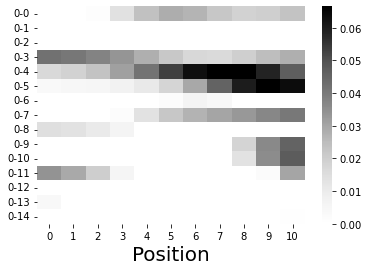

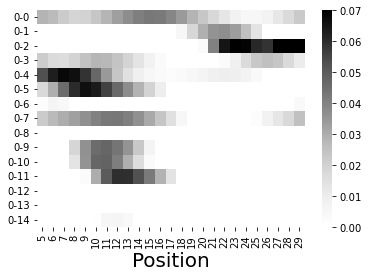

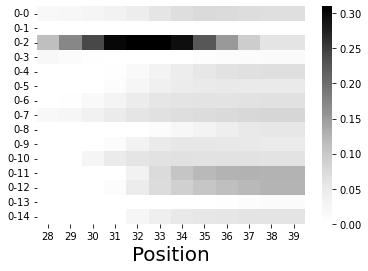

In [22]:
corr_per_field = {}
for ii,fr in field_range.iterrows():
    ph.heatmap(X_df_oneday.loc[fr['start']:fr['end'],:].T)



In [263]:
get_activation_per_day_field(X_df_oneday_null[:,:15],w=w,field_range=None)

array([-1.87121125e-11,  2.74244817e-02,  4.13313466e-02,  3.16999537e-02,
        9.18576092e-04,  2.23429928e-02,  3.40908901e-03,  1.44760289e-02,
        1.38839775e-02,  1.81308360e-02, -8.29796006e-12,  2.87938049e-04,
        8.89963494e-04,  1.87623138e-02,  5.58313749e-12])

In [285]:
field_id = 2
w=W_hat_ma[field_id]
X_df_oneday_null = None
activation_null_reshaped = shuffle_get_activation_per_day_field(X_df_oneday,X_df_oneday_null=X_df_oneday_null,w=w,field_range=None,min_roll=10,nrepeats=1000)



In [286]:
activation = get_activation_per_day_field(X_df_oneday,w=W_hat_ma[field_id])

(<Figure size 432x288 with 1 Axes>, <Axes: >)

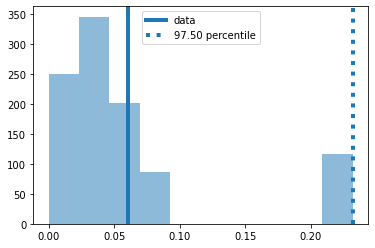

In [287]:
day=0
tr=0
ph.plot_shuffle_data_dist_with_thresh(activation_null_reshaped[day,tr],activation[day,tr]) 

In [295]:
w=W_hat_ma[field_id]
w=w/w.sum()

In [298]:
(X_df_.loc[:,(day,tr)] * w).sum()

0.060858212221697926

(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='Position'>)

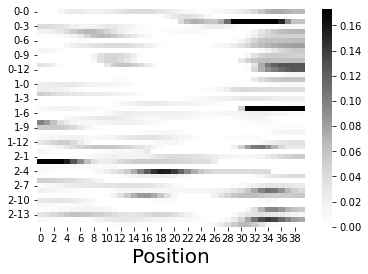

In [289]:
ph.heatmap(X_df_.T)

In [233]:
activation

0  0     1.876231e-02
   1     5.583137e-12
   2    -1.871211e-11
   3     2.742448e-02
   4     4.133135e-02
   5     3.169995e-02
   6     9.185761e-04
   7     2.234299e-02
   8     3.409089e-03
   9     1.447603e-02
   10    1.388398e-02
   11    1.813084e-02
   12   -8.297960e-12
   13    2.879380e-04
   14    8.899635e-04
dtype: float64

0.38902488383543943

In [191]:
W_hat_ma.apply(get_support,axis=0)

,0,1,2
0,0,10,28
1,13,26,39


In [188]:
get_support(W_hat_ma[2],extend=2)

array([28, 39])

In [159]:
W_hat_ma

,0,1,2
0,6.580072e-01,-1.234228e-09,-1.436739e-09
1,6.611394e-01,-1.576411e-09,-1.029170e-09
2,6.670436e-01,-1.681542e-09,-9.584362e-10
3,6.708926e-01,-1.650039e-09,-1.030332e-09
4,6.719989e-01,-1.518887e-09,-1.179629e-09
5,6.714105e-01,-1.277323e-09,-1.413536e-09
6,6.459549e-01,-5.176214e-10,-1.650962e-09
7,5.419627e-01,4.209445e-06,-1.698526e-09
8,3.424907e-01,3.607650e-03,-1.425940e-09
9,1.397445e-01,2.453978e-02,-9.011947e-10


In [157]:
W_hat_ma

,0,1,2
0,6.580072e-01,-1.234228e-09,-1.436739e-09
1,6.611394e-01,-1.576411e-09,-1.029170e-09
2,6.670436e-01,-1.681542e-09,-9.584362e-10
3,6.708926e-01,-1.650039e-09,-1.030332e-09
4,6.719989e-01,-1.518887e-09,-1.179629e-09
5,6.714105e-01,-1.277323e-09,-1.413536e-09
6,6.459549e-01,-5.176214e-10,-1.650962e-09
7,5.419627e-01,4.209445e-06,-1.698526e-09
8,3.424907e-01,3.607650e-03,-1.425940e-09
9,1.397445e-01,2.453978e-02,-9.011947e-10


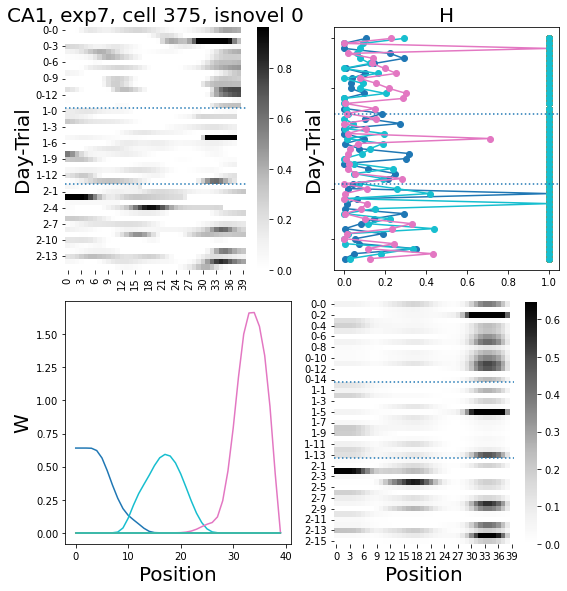

In [72]:
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)

In [33]:
from sklearn.decomposition import NMF

In [150]:
nmf = NMF(n_components=4)

In [151]:
ww=nmf.fit_transform(X_df.dropna(axis=0))
hh=nmf.components_

<Axes: >

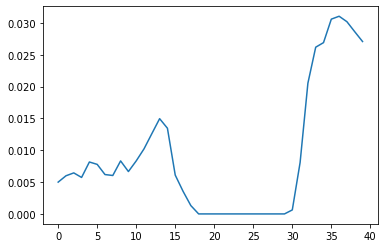

In [152]:
X_df_.median(axis=1).plot()

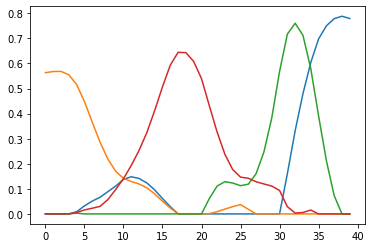

In [153]:
plt.plot(ww)